In [56]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.forecasting.stl import STLForecast

from datetime import datetime
import yfinance as yf

import matplotlib.pyplot as plt

from arch.unitroot import KPSS, ADF

from pmdarima.arima.utils import ndiffs

### Modeling in Python

In [2]:
start_date = datetime(2005, 1, 1)
end_date = datetime(2021, 1, 1)
df = yf.download(
    'SPY',
    start=start_date,
    end = end_date
)

[*********************100%***********************]  1 of 1 completed


In [13]:
df.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-12-31,121.300003,121.660004,120.800003,120.870003,86.040245,28648800
2005-01-03,121.559998,121.760002,119.900002,120.300003,85.634529,55748000


<AxesSubplot:xlabel='Date'>

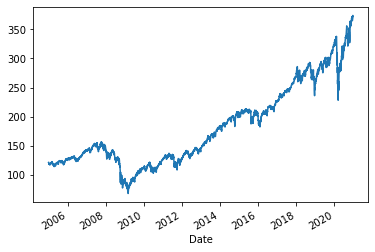

In [9]:
# plt.plot(range(len(df.Open.values)), df.Open.values)
df.Open.plot()

### resample the data to weekly data and make each year consistent

In [21]:
df1 = df.reset_index().resample('W', on='Date')['Open'].mean()
df1 = df1[df1.index.week < 53]
df1 = df1.asfreq('W').fillna(method='ffill')

C:\Users\stakk\AppData\Local\Temp\ipykernel_8528\912821389.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df1 = df1[df1.index.week < 53]


In [22]:
df1.head()

Date
2005-01-09    119.634000
2005-01-16    118.398000
2005-01-23    118.290001
2005-01-30    117.200000
2005-02-06    118.663998
Freq: W-SUN, Name: Open, dtype: float64

In [23]:
df1.index.freq

<Week: weekday=6>

### autocorrelation and partial autocorrelation functions

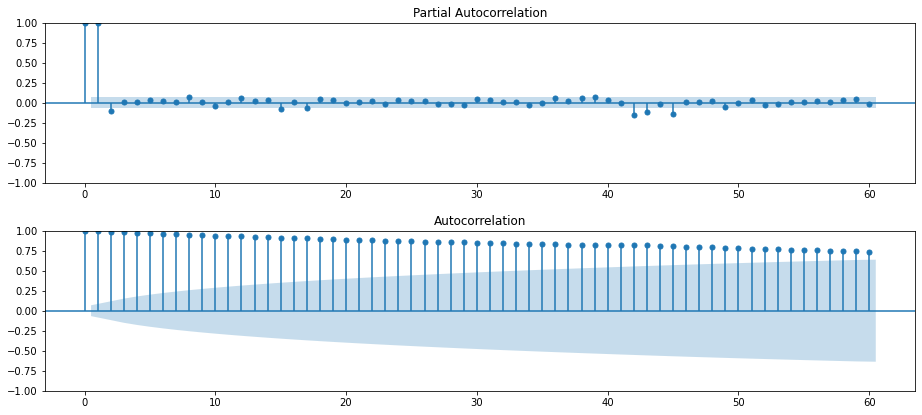

In [45]:
fig, axs = plt.subplots(2)
fig.tight_layout()
fig.set_size_inches((14, 6))
sm.graphics.tsa.plot_pacf(df1, lags=60, ax=axs[0])
sm.graphics.tsa.plot_acf(df1, lags=60, ax=axs[1])
plt.show()

### utilities to look at seasonality and trend

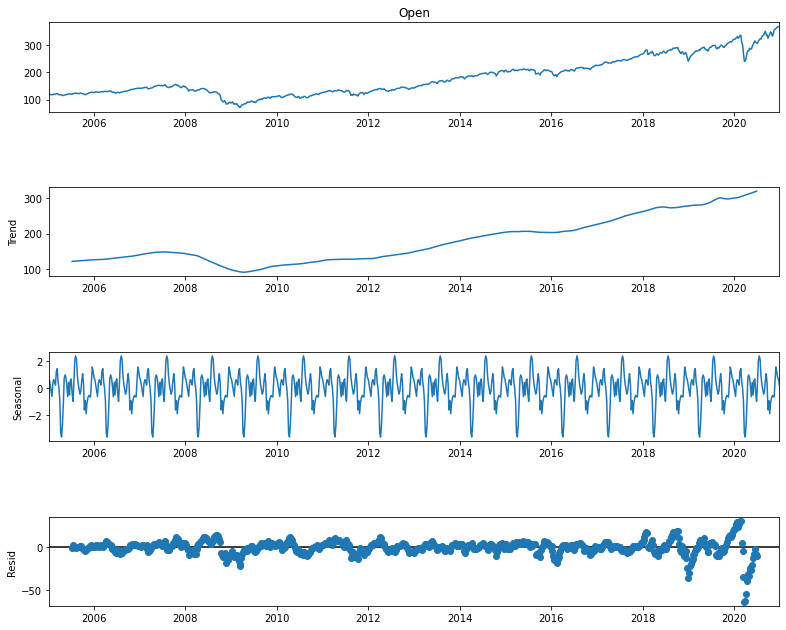

In [47]:
result = seasonal_decompose(df1, model='additive', period=52)
fig = result.plot()
fig.set_size_inches((12, 10))
plt.show()

### use the Augmented Dickey-Fuller and KPSS tests to check for stationarity

In [51]:
ADF(df1)

# Given the p-value of 0.997, we can reject our null hypothesis of the unit root, and we conclude that our process is weakly stationary.

Test Statistic,1.325
P-value,0.997
Lags,9


### use the pmdarima library to find good values for the differencing

In [53]:
# ADF Test:
ndiffs(df1, test='adf')

1

### AR model

In [55]:
mod = sm.tsa.arima.ARIMA(endog=df1, order=(1, 0, 0))
res = mod.fit()
print(res.summary())

C:\Users\stakk\miniconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  834
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2257.821
Date:                Sun, 07 Aug 2022   AIC                           4521.642
Time:                        15:43:36   BIC                           4535.821
Sample:                    01-09-2005   HQIC                          4527.078
                         - 12-27-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        182.3710    319.307      0.571      0.568    -443.458     808.200
ar.L1          0.9996      0.002    632.858      0.000       0.996       1.003
sigma2        13.0418      0.218     59.826      0.0

### use the STLForecast wrapper that removes seasonality and adds it back in

In [57]:
mod = STLForecast(
  df1, sm.tsa.arima.ARIMA,
  model_kwargs=dict(order=(1, 1, 0), trend="t")
)
res = mod.fit().model_result
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  834
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1965.555
Date:                Sun, 07 Aug 2022   AIC                           3937.110
Time:                        15:46:34   BIC                           3951.285
Sample:                    01-09-2005   HQIC                          3942.545
                         - 12-27-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2771      0.119      2.327      0.020       0.044       0.511
ar.L1          0.2502      0.022     11.402      0.000       0.207       0.293
sigma2         6.5618      0.184     35.641      0.0

### forecasting

In [63]:
STEPS = 20
forecasts_df = res.get_forecast(steps=STEPS).summary_frame()
forecasts_df.head(1)

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-01-03,347.672835,2.561599,342.652193,352.693478


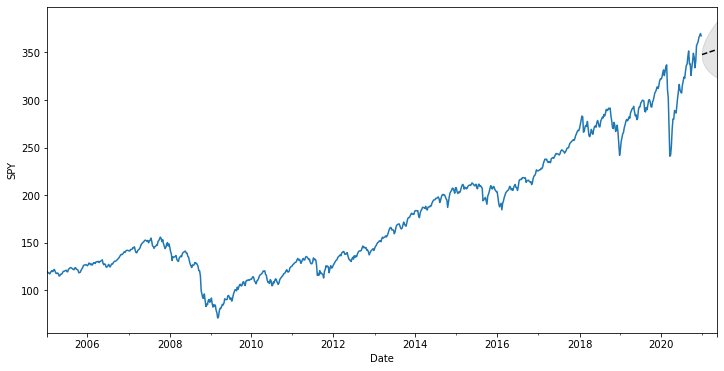

In [61]:
ax = df1.plot(figsize=(12, 6))
plt.ylabel('SPY')
forecasts_df['mean'].plot(style='k--')
ax.fill_between(
    forecasts_df.index,
    forecasts_df['mean_ci_lower'],
    forecasts_df['mean_ci_upper'],
    color='k',
    alpha=0.1
)